Выполнено: Мирзоян Шагане

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://www.dropbox.com/s/t1webrwixdlaacv/space_ga.txt

--2019-09-22 20:29:05--  https://www.dropbox.com/s/t1webrwixdlaacv/space_ga.txt
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.70.1
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: /s/raw/t1webrwixdlaacv/space_ga.txt [переход]
--2019-09-22 20:29:06--  https://www.dropbox.com/s/raw/t1webrwixdlaacv/space_ga.txt
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc8097d8e7f5418dd40e5936a43f.dl.dropboxusercontent.com/cd/0/inline/ApC1MQTvlIKCaAzC1bp2rFdSNV7F3C-WEhUXblfzIeXe__9jNjvBi7fXtofC9FtgwwUMJF7NdrF_evk7wU73XOnntVjshmVnhbR1dscCYLIqJWyz6wR1aJ4EZ4cpp2G463M/file# [переход]
--2019-09-22 20:29:06--  https://uc8097d8e7f5418dd40e5936a43f.dl.dropboxusercontent.com/cd/0/inline/ApC1MQTvlIKCaAzC1bp2rFdSNV7F3C-WEhUXblfzIeXe__9jNjvBi7fXtofC9FtgwwUMJF7NdrF_evk7wU73XOnntVjshmVnhbR1dscCYLIqJWyz6wR1aJ4EZ4cpp2G46

## Линейная регрессия с батч-оптимизацией(2 балла)

Рассмотрим случай, когда данных в выборке много. В таких случаях используется стохастическая или батч-оптимизация.

Загрузите данные из файла space_ga.csv и нормализуйте их. Мы будем предсказывать первый столбец по шести остальным. Эти данные получены с выборов в США в 1980 году.

In [3]:
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

In [4]:
original_data = pd.read_csv('space_ga.txt', header=None)
s = StandardScaler()
normilized_data = s.fit_transform(original_data)
data = pd.DataFrame(data = normilized_data, columns = range(7))

Как вы могли заметить, датасет больше предыдущего. На нём мы попробуем батч-оптимизацию.

Измените функцию для минимизации написанную на семинаре так, чтобы на вход они принимала дополнительный параметр — размер батча. Запустите функцию при разных размерах батча. Прокомментируйте результаты.

In [5]:
y = data[0].values
x = data.drop([0], axis=1).values

In [6]:
f = lambda w, X, y: np.mean((X @ w - y)**2) / 2
df = lambda w, X, y: np.mean((X @ w - y)[..., None] * X, axis=0)

In [7]:
np.random.seed(1568)
def g_descent(batch, learning_rate=0.001,  x_new=np.ones(x.shape[1])):
    x_old = np.zeros(x.shape[1])
    eps =  0.001
    loss = []
    while np.mean(abs(x_new - x_old)) > eps:
        x_old = x_new
        idxs = range(x.shape[0])
        rand_obj_idxs = random.sample(idxs, batch)
        new_step = df(x_old,x[rand_obj_idxs], y[rand_obj_idxs])
        x_new = x_old - learning_rate * new_step
        loss.append(f(x_new, x[rand_obj_idxs], y[rand_obj_idxs]))
    return x_new, loss
    

In [8]:
def print_loss(loss, batch):
    plt.plot(loss)
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.title('Loss via {} iterations with batch = {}'.format(len(loss), batch))
    plt.show()

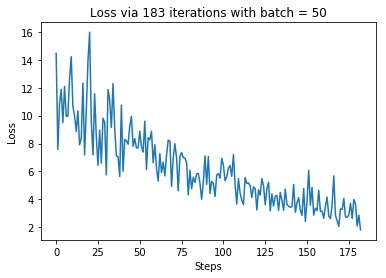

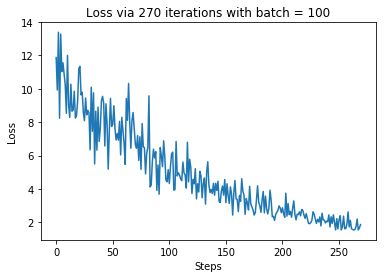

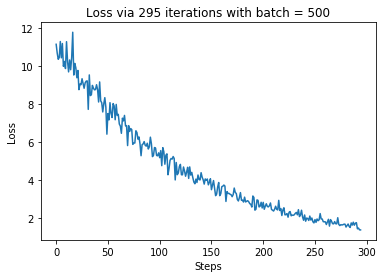

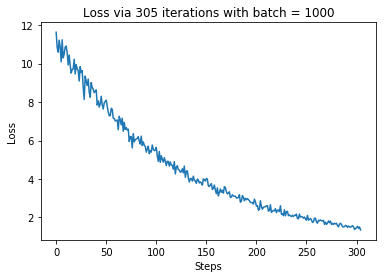

In [10]:
checking_batches = [50, 100, 500, 1000]
for i in checking_batches:
    w, l = g_descent(i)
    print_loss(l, i)

С увеличением размера батча видим меньшую зашумленность на графиках. Это связано с тем, что при маленьком размере выборки объектов для подсчета градиента, каждый из них играет бОльшую роль в направлении движении при спуске. Таким образом, если в батч попадает выброс, он с бОльшим "весом" смещает результат в направление, отличное от минимума функции.

При этом при увеличении размера батча можно также заметить еще одну особенность – увеличивается количество необходимых для сходимости ошибки шагов (порядка 400 при батче в 10 объектов и порядка 1000 при батче в 1000 объектов). Из-за того, что мы берем усреднее по многим градиентам в случае большого батча, шаги становятся меньше и нужно большее количество, чтобы свести ошибку к малому эпсилон (в данном случае eps = 0.001)

## Двумерная классификация(1 балл)

Решим задачу 2D классификации синтетических данных.



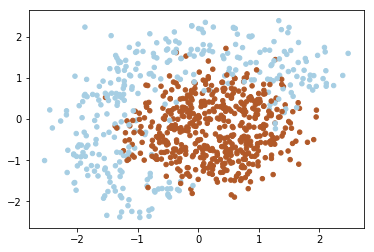

In [11]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()


Как можно заметить, данные сверху линейно неразделимы. Поэтому мы должны добавить дополнительные признаки(или использовать нелинейную модель). Можно заметить, что гиперплоскость разделяющая два класса принимает форму круга, поэтому мы можем добавить квадратичные признаки чтобы сделать классы линейно разделимыми.


![](kernel.png)

In [12]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    
    X_expanded = pd.DataFrame(X)
    #создаем квадраты
    for i in range(len(X.shape)):
        c = i + len(X.shape)
        X_expanded[c] = X_expanded[i]*X_expanded[i]
    
    X_expanded[4] = X_expanded[0]*X_expanded[1]
    X_expanded[5] = 1
    
    return X_expanded.values
   

In [13]:
X_expanded = expand(X) 

In [14]:
# simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape == dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")



Seems legit!


## Логистическая регрессия(3 балла)

Для классификации объектов мы будем получать вероятность того что объект принадлежит к классу '1'. Чтобы предсказывать вероятность мы будем использовать вывод линейной модели и логистической функции:


$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; | \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$



In [15]:
import math
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    scalar = X @ w
    p = 1 / (1 + np.exp(-scalar))
    return p
  
    

In [16]:
dummy_weights = np.linspace(-1, 1, 6)
ans_part1 = probability(X_expanded[:1, :], dummy_weights)[0]
ans_part1

0.3803998509843769

Для логистической регрессии оптимальное значение весов $w$ находится с помощью минимизации кросс-энтропии:


Loss для одного сэмпла: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss для нескольких сэмплов: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$




In [17]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    p = probability(X, w)
    loss = -y*np.log(p)+(1-y)*np.log(1-p)
    return loss.mean()
 


Т.к мы обучаем нашу модель с помощью градиентного спуска мы должны считать градиенты.
Для этого нам нужны производные функции потерь по каждому из весов.


$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

Выведите формулу для подсчета градиента.


In [20]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    p = probability(X, w)
    
    #тут упрощения, но за порядком умножения не следила, 
    #в переменной grad_w_l просто смотрела на размерности, тут пытаюсь понять, из чего эта переменная состоит
    
    #grad l by w = -(y*(1/p)*d_sigmoid+(1-y)*(1/(1-p))*d_sigmod)
    #d_sigmoid = p*(1-p)*X (потому что в Х в скалярном произведении)
    #-y*(1/p)*p*X*(1-p)+(1-y)*(1/(1-p)*p*X*(1-p) = y*X*(p-1)+(1-y)*p*X = -y*X+p*X= (p-y)*X 
    l = len(X)
    return (1 / l) * (X.T * (p - y)).sum(axis=1)
    

Вспомогательная функция для визуализации предсказаний:

In [21]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

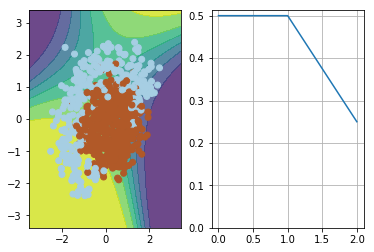

In [22]:
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение
В данной секции мы будем использовать функции, написанные вами, чтобы обучить наш классификатор с помощью стохастического градиентного спуска.


## Mini-batch SGD(1 балл)

Стохастический градиентный спуск берет рандомный батч из $m$ сэмплов на каждой итерации, подсчитывает градиент функции потерь на этом батче и делает шаг градиентного спуска:

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$




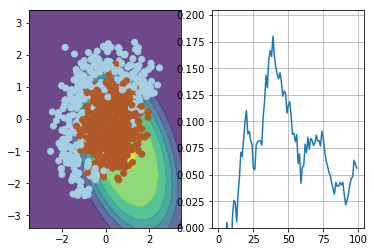

<Figure size 432x288 with 0 Axes>

In [23]:
np.random.seed(142)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate
n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
            
    step = compute_grad(X_expanded[ind], y[ind], w)
    w = w - eta * step

visualize(X, y, w, loss)
plt.clf()

## SGD with momentum(1 балл)

Momentum это метод позволяющий корректировать шаг SGD в нужное направление и уменьшать осцилляции как показано на рисунке. Данный эффект достигается с помощью добавления предыдущих шагов с коэффициентом $\alpha$ к текущему градиенту для каждого шага с обновлением весов.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)



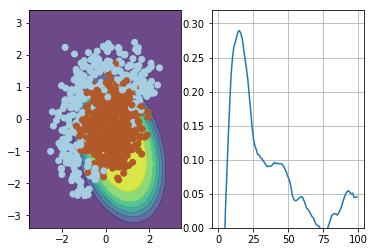

<Figure size 432x288 with 0 Axes>

In [25]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    
    g = compute_grad(X_expanded[ind], y[ind], w)
    nu = alpha * nu + eta * g
    w = w - nu
    
visualize(X, y, w, loss)
plt.clf()

## ADAM(2 балла)
Реализуйте метод ADAM, использующий градиенты и квадраты градиентов сглаженные экспоненциальным скользящим средним:


\begin{eqnarray}
m_t &=& \beta_1 m_{t-1} + (1-\beta_1) g_t\\
s_t &=& \beta_2 s_{t-1} + (1-\beta_2) g_t^2 \\
w_t &=& w_{t-1} - \eta \times \frac{\sqrt{ 1 -  \beta_2}}{ 1 - \beta_1} \times \frac{ m_t }{ \sqrt{s_t+eps}}
\end{eqnarray}

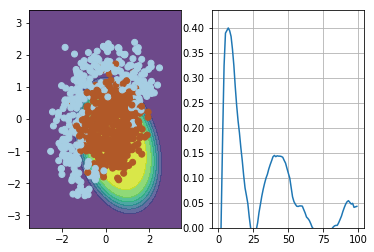

<Figure size 432x288 with 0 Axes>

In [26]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
beta_1 = 0.9 # moving average of gradient
beta_2 = 0.999 # moving average of gradient norm squared
g2 = None # we start with None so that you can update this value correctly on the first iteration
eps = 1e-8
m = np.zeros_like(w)
s = np.zeros_like(w)
n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    g = compute_grad(X_expanded[ind], y[ind], w)
    m = beta_1 * m + (1 - beta_1) * g
    s = beta_2 * s + (1 - beta_2) * g * g
    w = w - eta * math.sqrt(1-beta_2)/(1-beta_1)*m/ np.sqrt(s + eps)
    

visualize(X, y, w, loss)
plt.clf()